In [33]:
from preprocess import *
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt

In [9]:
wandb.init()
config = wandb.config

config.max_len = 11
config.buckets = 20

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

labels=["bed", "happy", "cat"]

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\tojer/.netrc


Saving vectors of label - 'happy': 100%|██████████████████████████████████████████| 1742/1742 [00:09<00:00, 185.25it/s]


# 1D and 2D Convolution on Audio Wave Spectrogram Image

In [10]:
# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()


In [12]:
# # Feature dimension
channels = 1
config.epochs = 50
config.batch_size = 100

num_classes = 3

X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)

0.0


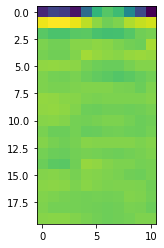

In [13]:
plt.imshow(X_train[100, :, :, 0])
print(y_train[100])

In [14]:
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [15]:
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len)

model = Sequential()
model.add(Flatten(input_shape=(config.buckets, config.max_len)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [16]:
wandb.init()
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

Epoch 1/50
98/98 [==============================] - 1s 8ms/step - loss: 32.4137 - accuracy: 0.4232 - val_loss: 17.6696 - val_accuracy: 0.5381
Epoch 2/50
98/98 [==============================] - 1s 7ms/step - loss: 10.9563 - accuracy: 0.6215 - val_loss: 8.5809 - val_accuracy: 0.6628
Epoch 3/50
98/98 [==============================] - 1s 6ms/step - loss: 6.5338 - accuracy: 0.6922 - val_loss: 6.6589 - val_accuracy: 0.6932
Epoch 4/50
98/98 [==============================] - 1s 7ms/step - loss: 5.1465 - accuracy: 0.7262 - val_loss: 5.2698 - val_accuracy: 0.7259
Epoch 5/50
98/98 [==============================] - 1s 6ms/step - loss: 4.1745 - accuracy: 0.7506 - val_loss: 4.4622 - val_accuracy: 0.7336
Epoch 6/50
98/98 [==============================] - 1s 6ms/step - loss: 3.6572 - accuracy: 0.7571 - val_loss: 4.2982 - val_accuracy: 0.7389
Epoch 7/50
98/98 [==============================] - 1s 6ms/step - loss: 3.3014 - accuracy: 0.7667 - val_loss: 3.9561 - val_accuracy: 0.7365
Epoch 8/50
98/98 

In [18]:
model = Sequential()
model.add(Conv2D(32, (3,3),
                input_shape = (config.buckets,config.max_len, channels), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                input_shape = (config.buckets,config.max_len, channels), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes,activation='softmax'))


In [19]:
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [20]:
wandb.init()
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

accuracy,▁▅▆▇▇▇▇█▇███████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇▇█▇██▇▇▇▇█▆▇▇▆▇▇▇████▅▇▇████▆███
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.80591
best_epoch,49
best_val_loss,1.07735
epoch,49
loss,0.76333
val_accuracy,0.75578


Epoch 1/50
98/98 [==============================] - 3s 20ms/step - loss: 0.8537 - accuracy: 0.6690 - val_loss: 0.4634 - val_accuracy: 0.8237
Epoch 2/50
98/98 [==============================] - 1s 12ms/step - loss: 0.3748 - accuracy: 0.8503 - val_loss: 0.3272 - val_accuracy: 0.8829
Epoch 3/50
98/98 [==============================] - 1s 10ms/step - loss: 0.2792 - accuracy: 0.8959 - val_loss: 0.3736 - val_accuracy: 0.8584
Epoch 4/50
98/98 [==============================] - 1s 10ms/step - loss: 0.2300 - accuracy: 0.9132 - val_loss: 0.3465 - val_accuracy: 0.8829
Epoch 5/50
98/98 [==============================] - 1s 10ms/step - loss: 0.1591 - accuracy: 0.9441 - val_loss: 0.2630 - val_accuracy: 0.9133
Epoch 6/50
98/98 [==============================] - 1s 10ms/step - loss: 0.1522 - accuracy: 0.9418 - val_loss: 0.2571 - val_accuracy: 0.9133
Epoch 7/50
98/98 [==============================] - 1s 11ms/step - loss: 0.0951 - accuracy: 0.9669 - val_loss: 0.5355 - val_accuracy: 0.8415
Epoch 8/50
98

# HyperParameter Tuning

In [66]:
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value = 32, max_value= 128, step=16),
        kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),
        activation = 'relu',
        input_shape=(config.buckets, config.max_len, channels)
        ),
        keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value = 32, max_value= 64, step=16),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
        activation = 'relu',
        input_shape=(config.buckets, config.max_len, channels),
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 32, max_value=128, step=16),
        activation='relu'
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer= tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2,1e-3])),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [67]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [68]:
tuner_search=RandomSearch(build_model, 
                         objective='val_accuracy',
                         max_trials = 5,
                         directory = 'output',
                         project_name= "Audio Transcribers")

In [69]:
tuner_search.search(X_train, y_train_hot, epochs=1, validation_split=.1)

Trial 5 Complete [00h 00m 03s]
val_accuracy: 0.8782051205635071

Best val_accuracy So Far: 0.8782051205635071
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit


# Tuning With For Loops

In [71]:
def build_model(fil, kernel, lr):
    
    model = keras.Sequential([
        keras.layers.Conv2D(
        filters= fil,
        kernel_size =kernel,
        activation = 'relu',
        input_shape=(config.buckets, config.max_len, channels)
        ),
        keras.layers.Conv2D(
        filters= fil,
        kernel_size =kernel,
        activation = 'relu',
        input_shape=(config.buckets, config.max_len, channels)
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
        units=fil,
        activation='relu'
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer= tf.keras.optimizers.Adam(lr),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [49]:
build_model(1,3,32).fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot))

Epoch 1/50
98/98 [==============================] - 1s 7ms/step - loss: 4.9669 - accuracy: 0.3252 - val_loss: 5.8332 - val_accuracy: 0.3285
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 4.7037 - accuracy: 0.3387 - val_loss: 4.7600 - val_accuracy: 0.3420
Epoch 3/50
98/98 [==============================] - 0s 5ms/step - loss: 3.5473 - accuracy: 0.3287 - val_loss: 2.5307 - val_accuracy: 0.3420
Epoch 4/50
98/98 [==============================] - 0s 5ms/step - loss: 4.7934 - accuracy: 0.3406 - val_loss: 3.3740 - val_accuracy: 0.3295
Epoch 5/50
98/98 [==============================] - 1s 7ms/step - loss: 3.2218 - accuracy: 0.3255 - val_loss: 2.8124 - val_accuracy: 0.3295
Epoch 6/50
98/98 [==============================] - 1s 6ms/step - loss: 3.2512 - accuracy: 0.3605 - val_loss: 5.0907 - val_accuracy: 0.3420
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 3.7672 - accuracy: 0.3332 - val_loss: 5.8342 - val_accuracy: 0.3285
Epoch 8/50
98/98 [==

In [72]:
for lr in range (1, 3):
    for kernel in range (3,5):
        for fil in range(32, 128,16):
            build_model(fil,kernel,lr).fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot))

Epoch 1/50
98/98 [==============================] - 2s 13ms/step - loss: 466213.3438 - accuracy: 0.3310 - val_loss: 1.4041 - val_accuracy: 0.3285
Epoch 2/50
98/98 [==============================] - 1s 11ms/step - loss: 1.3011 - accuracy: 0.3255 - val_loss: 1.8366 - val_accuracy: 0.3285
Epoch 3/50
98/98 [==============================] - 2s 16ms/step - loss: 1.2552 - accuracy: 0.3358 - val_loss: 1.2489 - val_accuracy: 0.3295
Epoch 4/50
98/98 [==============================] - 1s 11ms/step - loss: 1.2866 - accuracy: 0.3380 - val_loss: 1.1132 - val_accuracy: 0.3420
Epoch 5/50
98/98 [==============================] - 1s 11ms/step - loss: 1.2240 - accuracy: 0.3335 - val_loss: 1.1012 - val_accuracy: 0.3285
Epoch 6/50
98/98 [==============================] - 1s 11ms/step - loss: 1.3190 - accuracy: 0.3487 - val_loss: 1.3093 - val_accuracy: 0.3285
Epoch 7/50
98/98 [==============================] - 1s 12ms/step - loss: 1.3394 - accuracy: 0.3303 - val_loss: 1.1029 - val_accuracy: 0.3285
Epoch 8/

KeyboardInterrupt: 